# Krypton Lifetime

## Produce lifetime map 

### Author: JJGC

In [178]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Aug 24 15:28:36 2018


### Input files

In [179]:
from krcal.core.kr_types import KrFileName

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"


input_file_names  = ['dst_6284_trigger1_0000_7920.h5','dst_6285_trigger1_0000_7774.h5',
                    'dst_6286_trigger1_0000_7901.h5','dst_6287_trigger1_0000_7918.h5',
                    'dst_6288_trigger1_0000_7913.h5','dst_6289_trigger1_0000_8004.h5',
                    'dst_6290_trigger1_0000_4582.h5','dst_6291_trigger1_0000_4582.h5']





output_file_name  = 'ldst_6284_6291.h5'
map_file_name     = 'kr_maps_6284_6291.h5'
map_file_name_ts  = 'kr_maps_ts_6284_6291.h5'
emap_file_name    = 'kr_emap_6284_6291.h5'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts

In [8]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [9]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [10]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [11]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [12]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [13]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps

In [14]:
import krcal.dev.corrections       as corrections 


In [15]:
from numpy import pi

In [16]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [17]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [94]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [95]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6285_trigger1_0000_7774.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6286_trigger1_0000_7901.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6287_trigger1_0000_7918.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6288_trigger1_0000_7913.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6289_trigger1_0000_8004.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6290_trigger1_0000_4582.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6291_trigger1_0000_4582.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6284_6291.h5', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6284_6291.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6284_6291.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6284_6291.h5')

In [96]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [97]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 11365297


In [99]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [100]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [101]:
DT

array([     0.        , 519009.03299999, 173376.31100011, ...,
       518979.50099993, 518979.51600003, 518979.53900003])

### Ranges and binning

In [102]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Corrected S2e and Q

In [103]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(dst.X, dst.Y, None, dst.time, dst.S2e, dst.S2q)

calibration file : /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


In [104]:
kge = kr_event(dst, DT, E, Q)

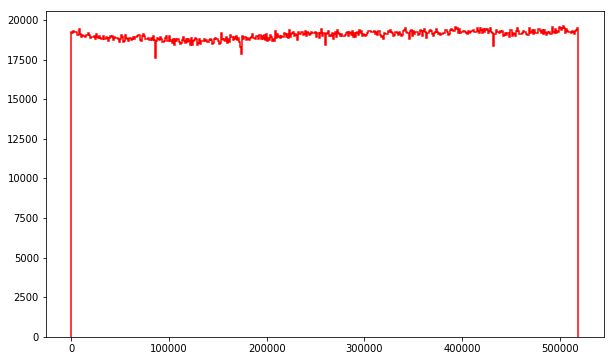

In [63]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

## Divide chamber in sector of R and Phi

In [122]:
RMAX       =180
NSECTORS   =10   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =15  # size of the wedge in degrees

R, PHI = rphi_sector_map(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [123]:
W = define_rphi_sectors(R, PHI, verbose=False)

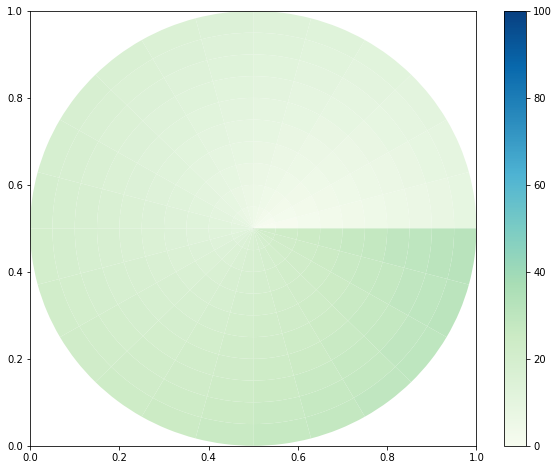

In [124]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [125]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, E, Q, W, verbose = False)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 56.193984031677246


### Time 

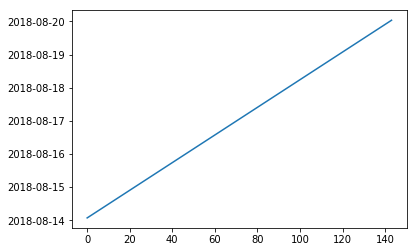

In [126]:
plt.plot(krTimes.timeStamps)

### Event distribution

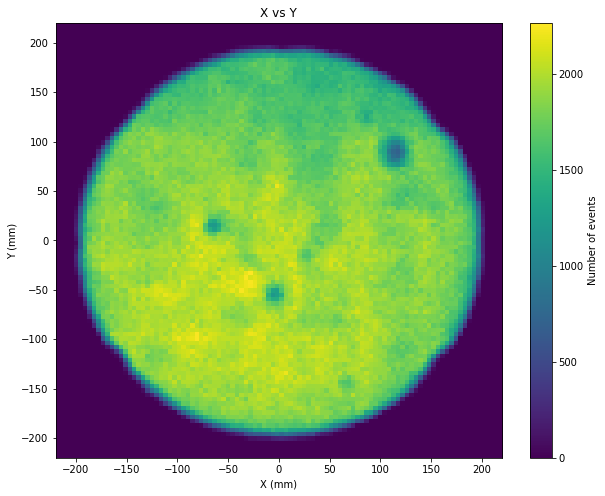

In [114]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 504214.0


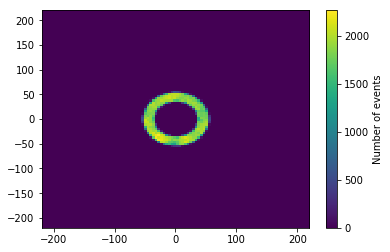

In [127]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=2)

number of events in sector = 106318.0
number of events in sector = 307938.0
number of events in sector = 504214.0
number of events in sector = 703892.0
number of events in sector = 909964.0
number of events in sector = 1102272.0
number of events in sector = 1288740.0
number of events in sector = 1458237.0
number of events in sector = 1620848.0
number of events in sector = 1784096.0


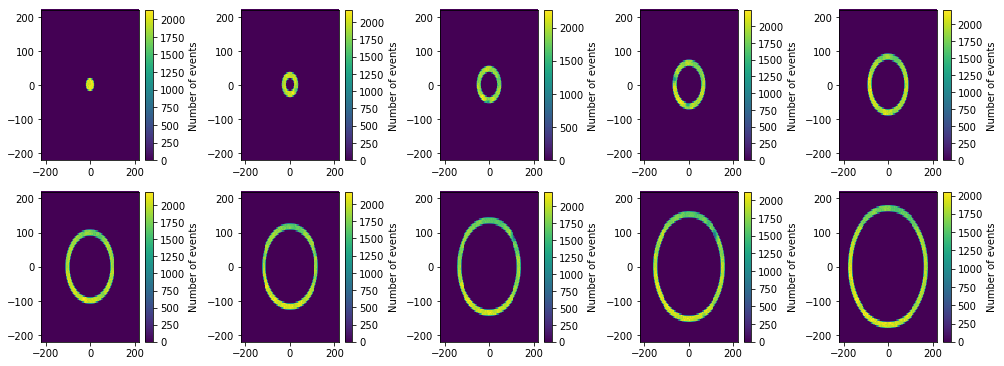

In [128]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, nx = 4, ny = 5,figsize=(14,10))

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [129]:
DT[-1] /30000

17.29931796666781

In [130]:
XT = 30000

In [131]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12500),
                         energy = 'S2e', fit = FitType.unbined)
                    

wedge = 0: chi2 =     1.04 ; e0 = 11985.46 +-  28.39; lt =  2202.21 +-  55.53;
wedge = 1: chi2 =     0.97 ; e0 = 12029.47 +-  31.62; lt =  2175.21 +-  67.21;
wedge = 2: chi2 =     0.88 ; e0 = 12031.57 +-  30.67; lt =  2190.79 +-  73.29;
wedge = 3: chi2 =     0.93 ; e0 = 12041.09 +-  30.94; lt =  2193.53 +-  54.25;
wedge = 4: chi2 =     0.96 ; e0 = 12057.30 +-  34.73; lt =  2167.32 +-  55.22;
wedge = 5: chi2 =     1.03 ; e0 = 12039.16 +-  28.37; lt =  2186.47 +-  55.81;
wedge = 6: chi2 =     0.93 ; e0 = 12029.36 +-  26.27; lt =  2182.87 +-  71.25;
wedge = 7: chi2 =     0.95 ; e0 = 12005.20 +-  32.59; lt =  2198.06 +-  58.33;
wedge = 8: chi2 =     0.94 ; e0 = 11997.02 +-  32.19; lt =  2182.23 +-  56.52;
wedge = 9: chi2 =     0.88 ; e0 = 11980.38 +-  30.98; lt =  2182.97 +-  58.00;
wedge = 10: chi2 =     1.00 ; e0 = 11950.64 +-  26.58; lt =  2193.67 +-  72.51;
wedge = 11: chi2 =     1.03 ; e0 = 11937.73 +-  30.62; lt =  2185.53 +-  51.86;
wedge = 12: chi2 =     1.07 ; e0 = 11918.37 +-  33

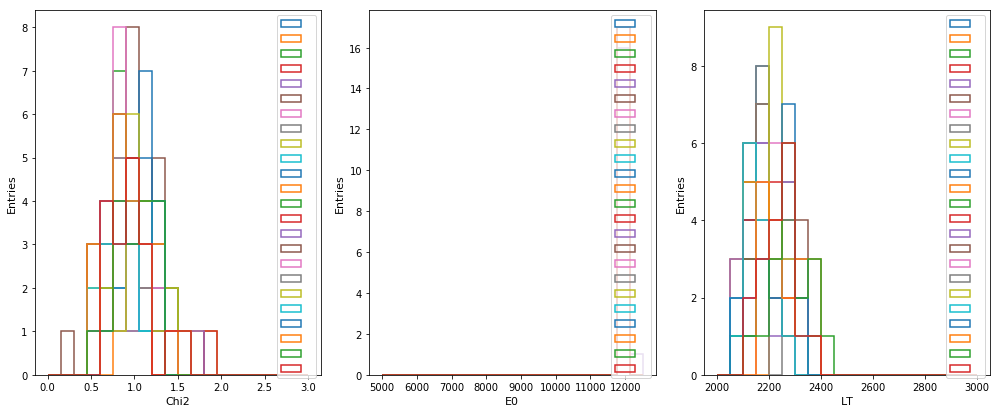

In [132]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

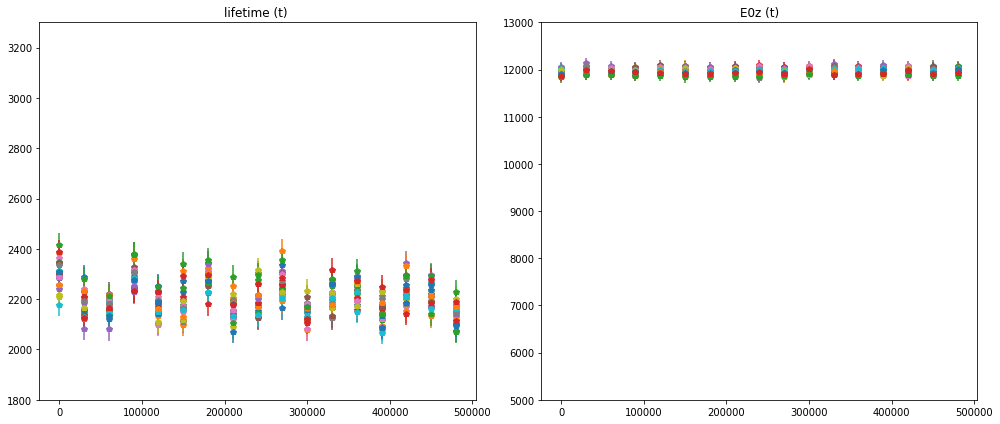

In [133]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3300))

In [134]:
fps = fit_fcs_in_sectors(1, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

wedge = 0: chi2 =     0.89 ; e0 = 11957.06 +-  21.63; lt =  2184.06 +-  58.25;
wedge = 1: chi2 =     0.86 ; e0 = 11924.89 +-  26.29; lt =  2215.08 +-  58.64;
wedge = 2: chi2 =     0.87 ; e0 = 11923.23 +-  23.08; lt =  2255.44 +-  52.59;
wedge = 3: chi2 =     0.93 ; e0 = 12025.62 +-  29.56; lt =  2215.32 +-  71.38;
wedge = 4: chi2 =     0.92 ; e0 = 12050.68 +-  22.94; lt =  2211.49 +-  59.51;
wedge = 5: chi2 =     0.89 ; e0 = 12031.51 +-  22.23; lt =  2198.53 +-  41.28;
wedge = 6: chi2 =     0.93 ; e0 = 11986.98 +-  20.64; lt =  2228.70 +-  54.01;
wedge = 7: chi2 =     0.85 ; e0 = 12024.18 +-  27.81; lt =  2165.41 +-  60.81;
wedge = 8: chi2 =     0.84 ; e0 = 11973.48 +-  21.80; lt =  2165.78 +-  48.21;
wedge = 9: chi2 =     0.86 ; e0 = 11855.42 +-  24.76; lt =  2222.31 +-  64.73;
wedge = 10: chi2 =     0.92 ; e0 = 11796.58 +-  24.46; lt =  2228.06 +-  61.20;
wedge = 11: chi2 =     0.81 ; e0 = 11749.04 +-  23.27; lt =  2246.47 +-  67.70;
wedge = 12: chi2 =     0.89 ; e0 = 11797.33 +-  23

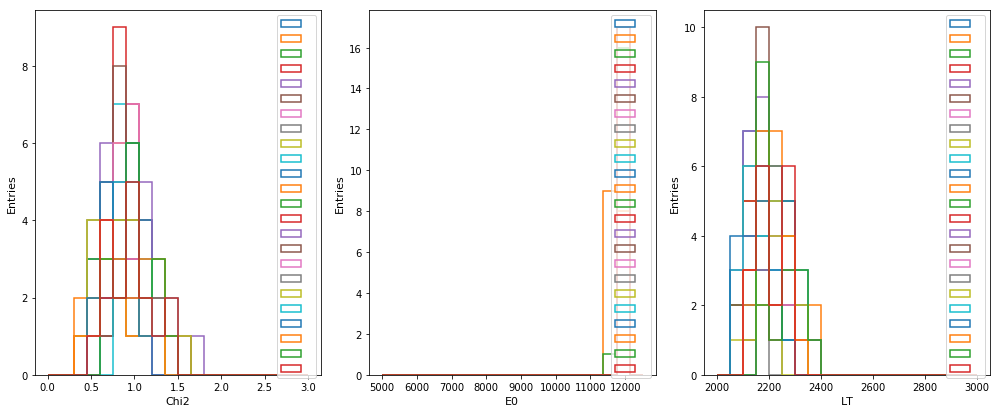

In [135]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts )

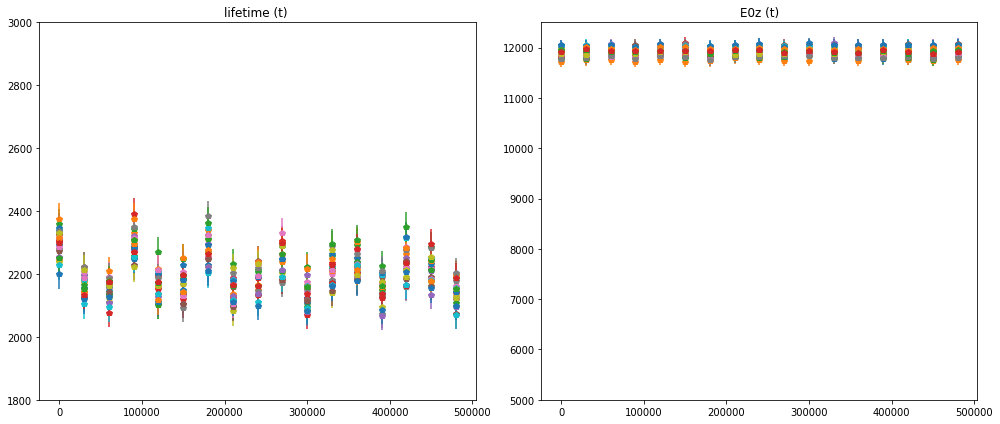

In [136]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [137]:
fps = fit_fcs_in_sectors(2, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



wedge = 0: chi2 =     0.86 ; e0 = 11936.85 +-  16.84; lt =  2225.27 +-  57.83;
wedge = 1: chi2 =     0.85 ; e0 = 11954.06 +-  19.89; lt =  2257.90 +-  67.71;
wedge = 2: chi2 =     0.87 ; e0 = 12175.71 +-  23.52; lt =  2186.63 +-  55.52;
wedge = 3: chi2 =     0.92 ; e0 = 12372.05 +-  15.50; lt =  2128.47 +-  49.24;
wedge = 4: chi2 =     0.89 ; e0 = 12231.78 +-  21.41; lt =  2167.45 +-  52.85;
wedge = 5: chi2 =     0.94 ; e0 = 12003.05 +-  19.76; lt =  2214.82 +-  58.35;
wedge = 6: chi2 =     1.00 ; e0 = 11945.44 +-  20.44; lt =  2199.14 +-  57.29;
wedge = 7: chi2 =     0.96 ; e0 = 11961.74 +-  18.32; lt =  2161.82 +-  50.54;
wedge = 8: chi2 =     0.86 ; e0 = 11795.27 +-  13.47; lt =  2229.99 +-  50.56;
wedge = 9: chi2 =     0.99 ; e0 = 11762.65 +-  17.29; lt =  2224.94 +-  61.29;
wedge = 10: chi2 =     0.83 ; e0 = 11864.09 +-  21.42; lt =  2146.38 +-  58.98;
wedge = 11: chi2 =     0.87 ; e0 = 11740.39 +-  22.17; lt =  2185.97 +-  61.95;
wedge = 12: chi2 =     0.84 ; e0 = 11568.91 +-  13

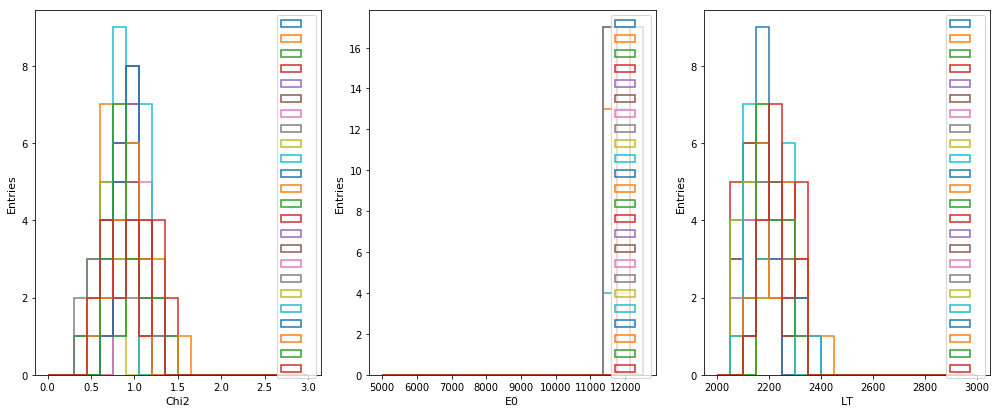

In [138]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

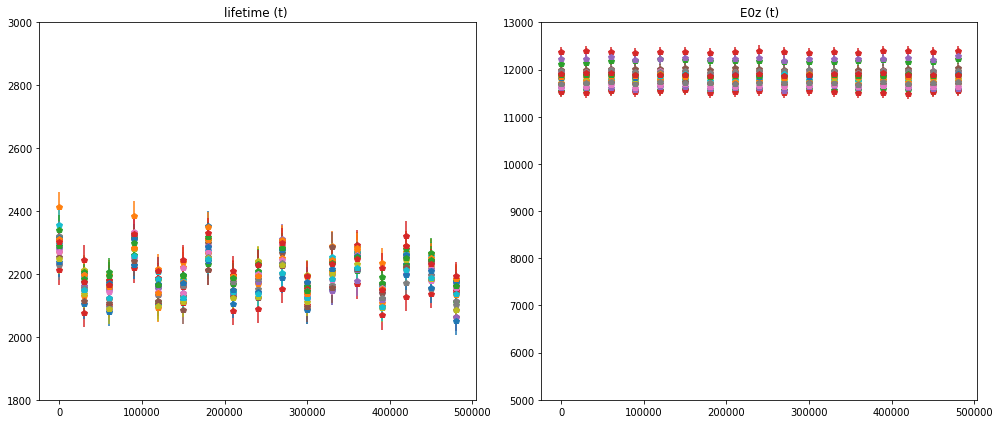

In [140]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3000))

In [141]:
fps = fit_fcs_in_sectors(3, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.97 ; e0 = 12086.40 +-  12.75; lt =  2185.23 +-  50.69;
wedge = 1: chi2 =     0.88 ; e0 = 12187.76 +-  13.68; lt =  2202.39 +-  58.33;
wedge = 2: chi2 =     1.02 ; e0 = 12358.78 +-  20.05; lt =  2174.18 +-  56.79;
wedge = 3: chi2 =     0.92 ; e0 = 12389.76 +-  22.70; lt =  2154.24 +-  51.48;
wedge = 4: chi2 =     0.91 ; e0 = 12153.48 +-  20.14; lt =  2189.10 +-  43.87;
wedge = 5: chi2 =     0.95 ; e0 = 11863.17 +-  18.17; lt =  2233.72 +-  45.30;
wedge = 6: chi2 =     0.90 ; e0 = 11766.26 +-  13.44; lt =  2215.91 +-  46.38;
wedge = 7: chi2 =     0.93 ; e0 = 11781.72 +-  17.64; lt =  2202.17 +-  49.92;
wedge = 8: chi2 =     0.86 ; e0 = 11729.90 +-  19.38; lt =  2195.85 +-  51.35;
wedge = 9: chi2 =     1.00 ; e0 = 11676.78 +-  14.45; lt =  2186.10 +-  45.08;
wedge = 10: chi2 =     0.90 ; e0 = 11683.17 +-  13.66; lt =  2165.84 +-  48.17;
wedge = 11: chi2 =     0.86 ; e0 = 11578.09 +-  19.64; lt =  2180.54 +-  62.69;
wedge = 12: chi2 =     0.91 ; e0 = 11451.47 +-  18

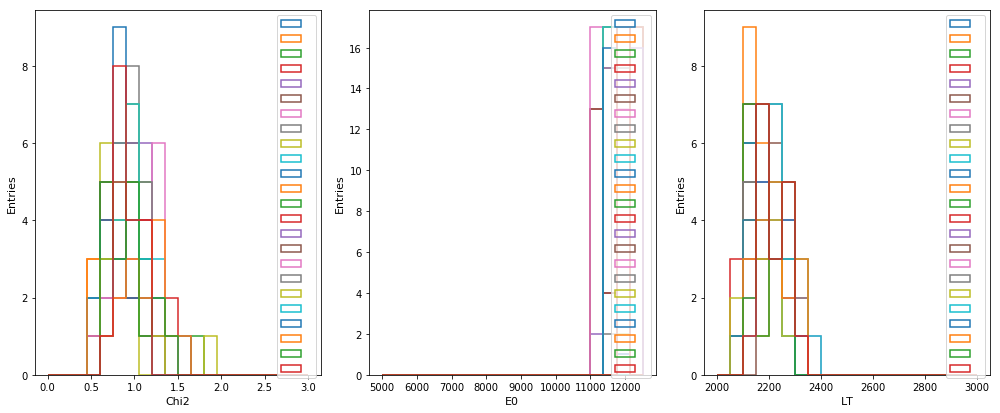

In [142]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

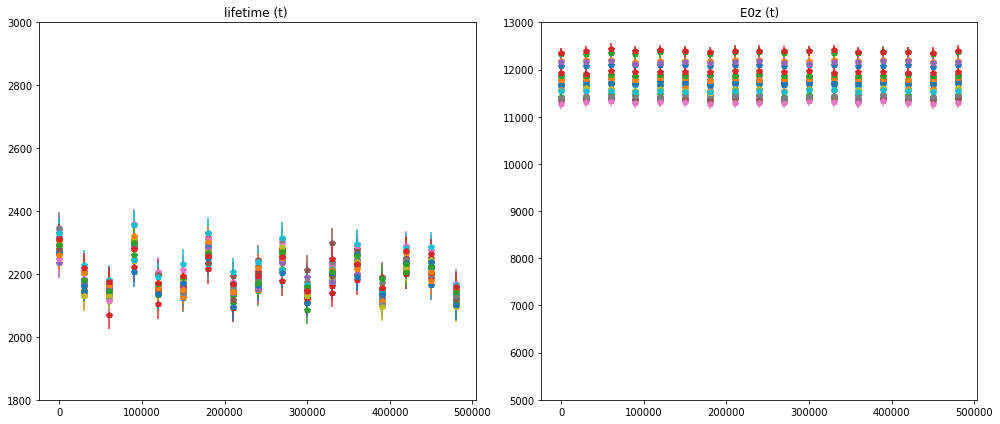

In [143]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3000))

In [144]:
fps = fit_fcs_in_sectors(4, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     1.00 ; e0 = 11966.94 +-  13.24; lt =  2205.24 +-  45.30;
wedge = 1: chi2 =     0.91 ; e0 = 12093.34 +-  11.49; lt =  2196.60 +-  50.01;
wedge = 2: chi2 =     0.96 ; e0 = 12133.22 +-  11.75; lt =  2184.03 +-  51.22;
wedge = 3: chi2 =     0.92 ; e0 = 12029.49 +-  16.29; lt =  2195.89 +-  47.00;
wedge = 4: chi2 =     0.91 ; e0 = 11864.50 +-  18.49; lt =  2230.64 +-  51.29;
wedge = 5: chi2 =     0.97 ; e0 = 11755.06 +-  17.60; lt =  2224.23 +-  49.62;
wedge = 6: chi2 =     0.99 ; e0 = 11583.70 +-  14.40; lt =  2234.14 +-  44.85;
wedge = 7: chi2 =     0.95 ; e0 = 11650.11 +-  14.50; lt =  2190.76 +-  41.86;
wedge = 8: chi2 =     0.91 ; e0 = 11567.66 +-  16.78; lt =  2170.02 +-  47.16;
wedge = 9: chi2 =     0.89 ; e0 = 11409.59 +-  14.50; lt =  2189.41 +-  47.70;
wedge = 10: chi2 =     1.07 ; e0 = 11306.58 +-  17.41; lt =  2198.33 +-  56.76;
wedge = 11: chi2 =     1.00 ; e0 = 11270.27 +-  15.48; lt =  2199.29 +-  54.04;
wedge = 12: chi2 =     0.89 ; e0 = 11223.00 +-  13

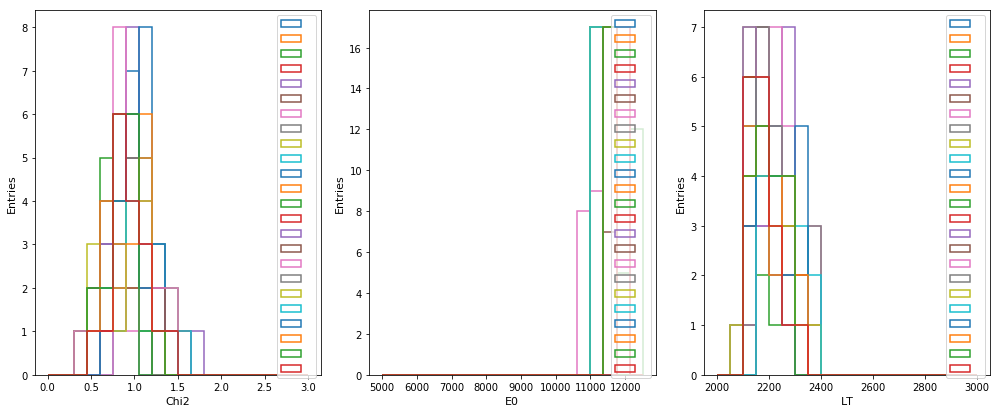

In [145]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

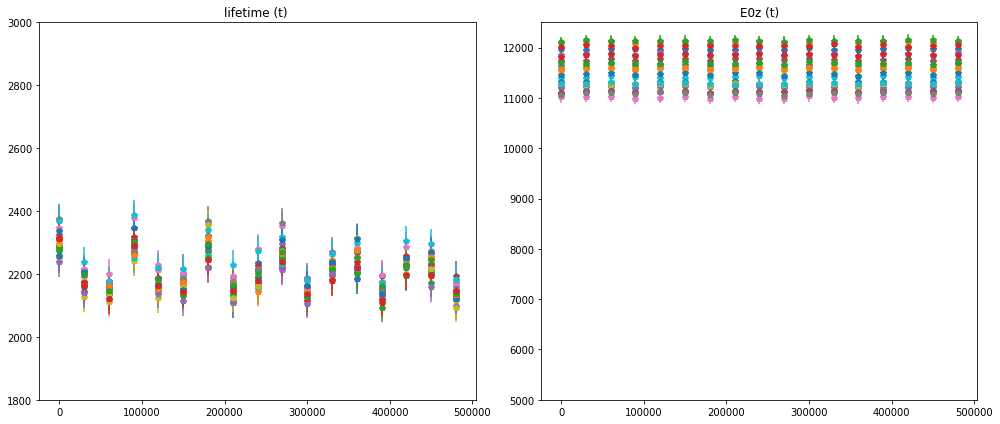

In [146]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [147]:
fps = fit_fcs_in_sectors(5, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.91 ; e0 = 11697.38 +-  11.70; lt =  2216.00 +-  52.06;
wedge = 1: chi2 =     0.93 ; e0 = 11878.51 +-  10.55; lt =  2206.48 +-  48.09;
wedge = 2: chi2 =     0.97 ; e0 = 11795.37 +-  15.61; lt =  2231.06 +-  53.71;
wedge = 3: chi2 =     1.01 ; e0 = 11713.96 +-  13.10; lt =  2249.76 +-  40.71;
wedge = 4: chi2 =     1.01 ; e0 = 11759.24 +-  11.78; lt =  2215.97 +-  38.73;
wedge = 5: chi2 =     0.93 ; e0 = 11790.68 +-  17.95; lt =  2191.70 +-  37.14;
wedge = 6: chi2 =     0.89 ; e0 = 11517.73 +-  13.29; lt =  2221.38 +-  32.66;
wedge = 7: chi2 =     0.91 ; e0 = 11525.11 +-  14.57; lt =  2173.48 +-  33.07;
wedge = 8: chi2 =     0.89 ; e0 = 11234.14 +-  12.38; lt =  2222.92 +-  45.96;
wedge = 9: chi2 =     0.94 ; e0 = 11122.97 +-  14.32; lt =  2187.45 +-  50.38;
wedge = 10: chi2 =     1.06 ; e0 = 10976.95 +-  17.66; lt =  2209.78 +-  59.50;
wedge = 11: chi2 =     0.88 ; e0 = 11077.11 +-  10.65; lt =  2173.93 +-  50.10;
wedge = 12: chi2 =     0.97 ; e0 = 10936.63 +-  10

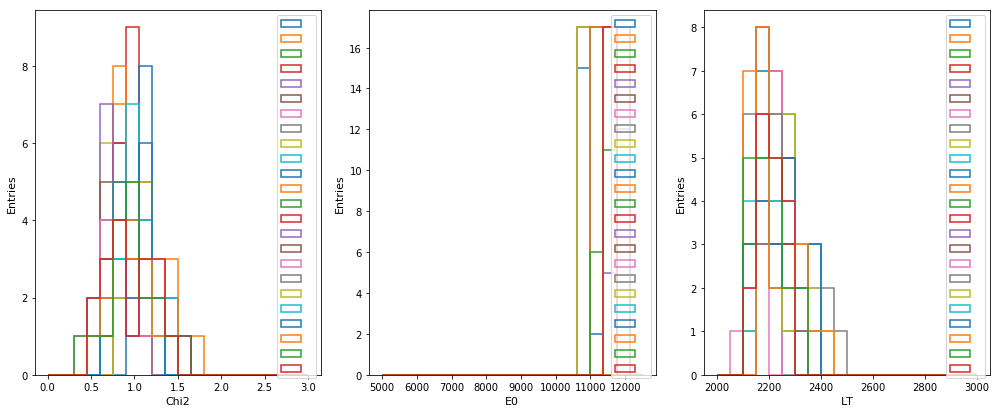

In [148]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

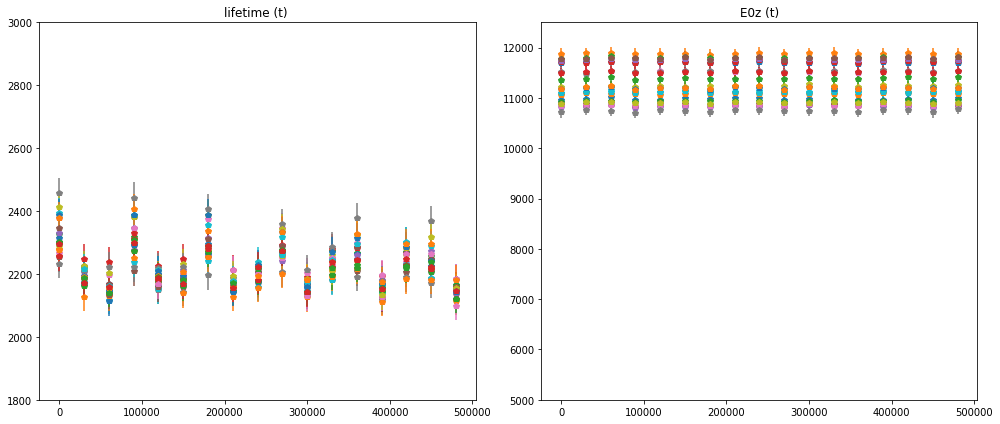

In [149]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [150]:
fps = fit_fcs_in_sectors(6, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.93 ; e0 = 11468.05 +-  12.40; lt =  2199.24 +-  49.09;
wedge = 1: chi2 =     0.97 ; e0 = 11739.01 +-  11.82; lt =  2190.60 +-  50.39;
wedge = 2: chi2 =     0.86 ; e0 = 11612.95 +-   9.57; lt =  2232.47 +-  43.40;
wedge = 3: chi2 =     1.02 ; e0 = 11650.77 +-  13.08; lt =  2215.62 +-  43.08;
wedge = 4: chi2 =     0.91 ; e0 = 11579.98 +-  15.28; lt =  2244.81 +-  32.84;
wedge = 5: chi2 =     0.95 ; e0 = 11628.83 +-  14.81; lt =  2211.43 +-  27.85;
wedge = 6: chi2 =     1.04 ; e0 = 11355.74 +-  13.88; lt =  2236.11 +-  23.18;
wedge = 7: chi2 =     0.99 ; e0 = 11297.33 +-  16.18; lt =  2186.24 +-  33.09;
wedge = 8: chi2 =     1.04 ; e0 = 10995.60 +-   9.77; lt =  2200.98 +-  38.97;
wedge = 9: chi2 =     1.01 ; e0 = 10886.46 +-  19.37; lt =  2169.10 +-  54.04;
wedge = 10: chi2 =     0.93 ; e0 = 10717.31 +-  15.21; lt =  2189.55 +-  54.02;
wedge = 11: chi2 =     0.89 ; e0 = 10802.57 +-  13.58; lt =  2170.13 +-  55.57;
wedge = 12: chi2 =     1.06 ; e0 = 10615.72 +-  17

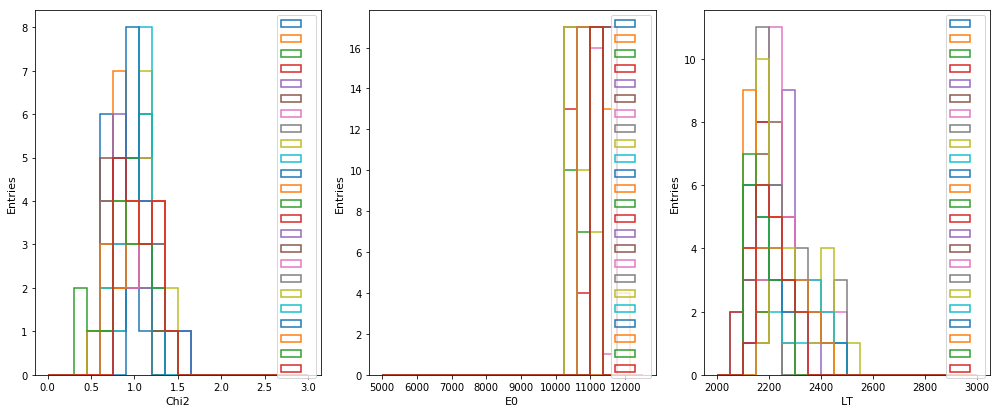

In [151]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

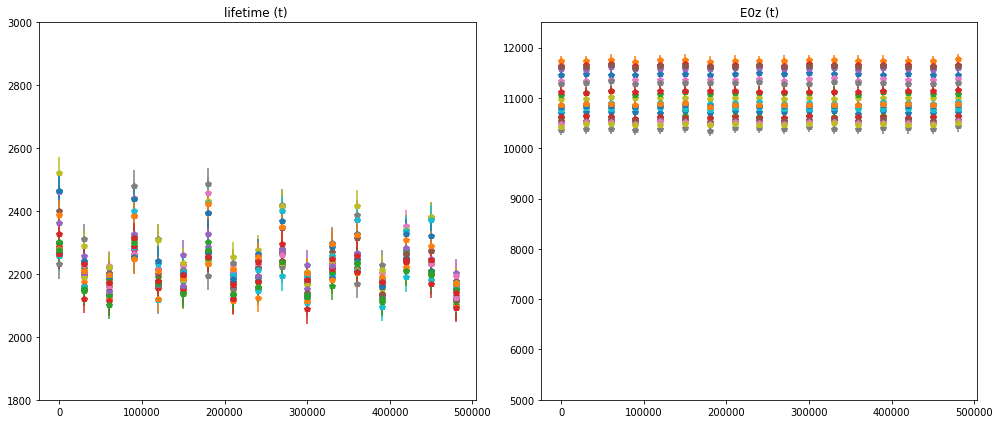

In [152]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [153]:
fps = fit_fcs_in_sectors(7, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     1.01 ; e0 = 11137.58 +-   8.36; lt =  2192.89 +-  43.57;
wedge = 1: chi2 =     0.91 ; e0 = 11450.49 +-  14.17; lt =  2187.22 +-  48.86;
wedge = 2: chi2 =     0.94 ; e0 = 11423.58 +-  11.99; lt =  2228.82 +-  42.57;
wedge = 3: chi2 =     1.03 ; e0 = 11461.99 +-  14.41; lt =  2206.78 +-  39.20;
wedge = 4: chi2 =     0.96 ; e0 = 11361.50 +-  10.35; lt =  2225.58 +-  22.98;
wedge = 5: chi2 =     0.90 ; e0 = 11326.10 +-  14.33; lt =  2225.08 +-  15.14;
wedge = 6: chi2 =     1.03 ; e0 = 11078.87 +-  11.62; lt =  2220.46 +-  18.20;
wedge = 7: chi2 =     1.02 ; e0 = 10949.85 +-  15.30; lt =  2186.50 +-  26.42;
wedge = 8: chi2 =     0.98 ; e0 = 10644.77 +-  13.76; lt =  2188.68 +-  35.85;
wedge = 9: chi2 =     0.95 ; e0 = 10515.46 +-  10.53; lt =  2169.96 +-  46.16;
wedge = 10: chi2 =     1.00 ; e0 = 10378.86 +-  11.60; lt =  2187.59 +-  50.42;
wedge = 11: chi2 =     1.04 ; e0 = 10438.88 +-  12.18; lt =  2175.66 +-  54.12;
wedge = 12: chi2 =     0.95 ; e0 = 10293.44 +-  15

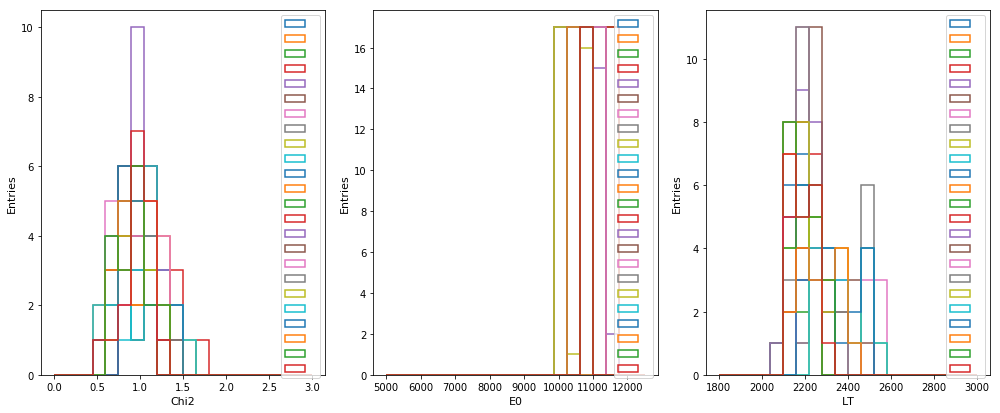

In [154]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

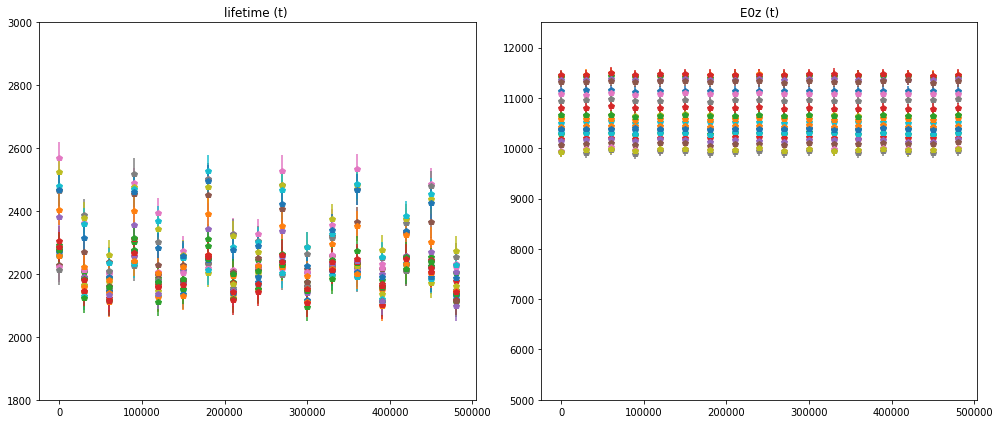

In [155]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [156]:
fps = fit_fcs_in_sectors(8, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.97 ; e0 = 10722.44 +-  12.85; lt =  2192.50 +-  52.08;
wedge = 1: chi2 =     1.01 ; e0 = 10977.01 +-  15.28; lt =  2181.49 +-  48.44;
wedge = 2: chi2 =     0.96 ; e0 = 11105.31 +-  15.35; lt =  2195.27 +-  50.30;
wedge = 3: chi2 =     0.96 ; e0 = 11026.40 +-  10.77; lt =  2219.47 +-  30.12;
wedge = 4: chi2 =     1.05 ; e0 = 10934.63 +-  13.45; lt =  2247.63 +-  19.08;
wedge = 5: chi2 =     1.03 ; e0 = 10859.56 +-  10.65; lt =  2257.85 +-  22.30;
wedge = 6: chi2 =     0.92 ; e0 = 10580.42 +-  14.62; lt =  2234.32 +-  14.80;
wedge = 7: chi2 =     1.00 ; e0 = 10421.57 +-  16.76; lt =  2199.71 +-  20.92;
wedge = 8: chi2 =     0.92 ; e0 = 10134.09 +-  13.86; lt =  2200.65 +-  29.89;
wedge = 9: chi2 =     0.96 ; e0 =  9981.02 +-  10.33; lt =  2178.52 +-  38.69;
wedge = 10: chi2 =     0.99 ; e0 =  9951.41 +-   9.67; lt =  2158.61 +-  47.38;
wedge = 11: chi2 =     1.02 ; e0 =  9973.69 +-  10.83; lt =  2142.48 +-  46.20;
wedge = 12: chi2 =     0.93 ; e0 =  9807.09 +-  13

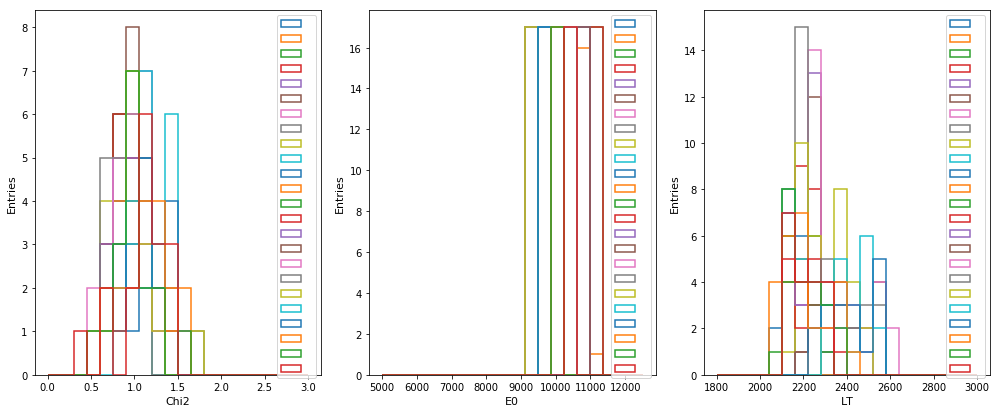

In [157]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

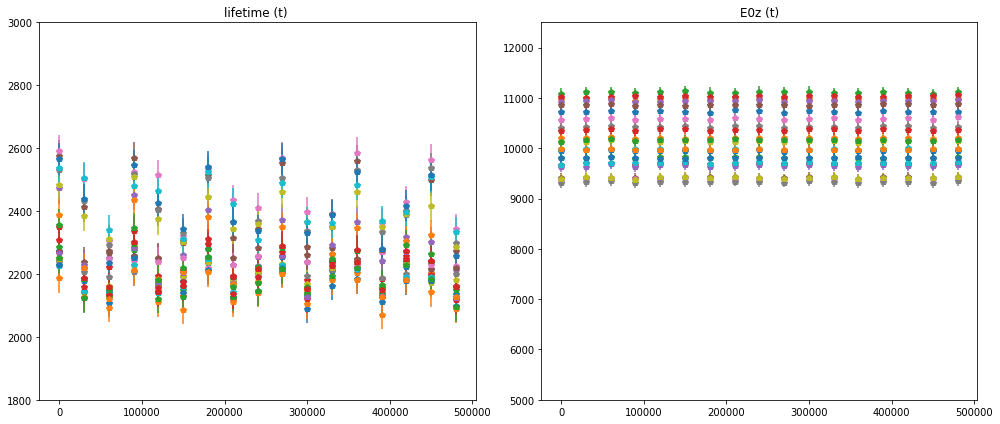

In [158]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [159]:
fps = fit_fcs_in_sectors(9, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.92 ; e0 = 10195.79 +-  15.91; lt =  2132.38 +-  50.57;
wedge = 1: chi2 =     0.93 ; e0 = 10274.81 +-  14.10; lt =  2175.27 +-  46.85;
wedge = 2: chi2 =     1.06 ; e0 = 10464.33 +-  15.75; lt =  2150.75 +-  42.57;
wedge = 3: chi2 =     0.85 ; e0 = 10469.60 +-  13.54; lt =  2169.76 +-  31.64;
wedge = 4: chi2 =     1.05 ; e0 = 10298.27 +-   9.92; lt =  2231.18 +-  19.84;
wedge = 5: chi2 =     0.97 ; e0 = 10229.77 +-  20.08; lt =  2230.77 +-  20.06;
wedge = 6: chi2 =     0.96 ; e0 =  9879.20 +-  18.76; lt =  2231.74 +-  23.74;
wedge = 7: chi2 =     0.92 ; e0 =  9689.53 +-  12.49; lt =  2219.56 +-  22.38;
wedge = 8: chi2 =     0.90 ; e0 =  9550.20 +-  16.13; lt =  2146.95 +-  31.60;
wedge = 9: chi2 =     1.06 ; e0 =  9345.71 +-  11.55; lt =  2140.52 +-  37.58;
wedge = 10: chi2 =     1.02 ; e0 =  9307.82 +-  12.33; lt =  2134.29 +-  53.89;
wedge = 11: chi2 =     0.95 ; e0 =  9268.75 +-  14.43; lt =  2129.78 +-  51.13;
wedge = 12: chi2 =     0.91 ; e0 =  9234.04 +-  16

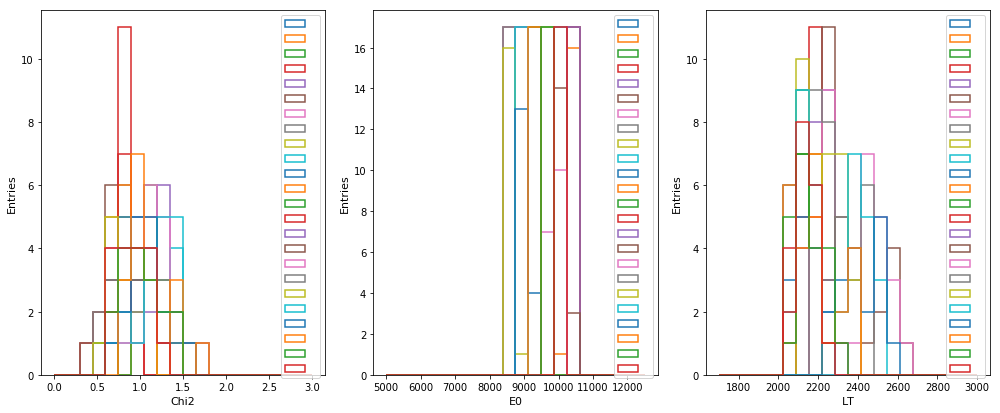

In [160]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1700, 3000))
print_fit_sectors_pars(fpts)

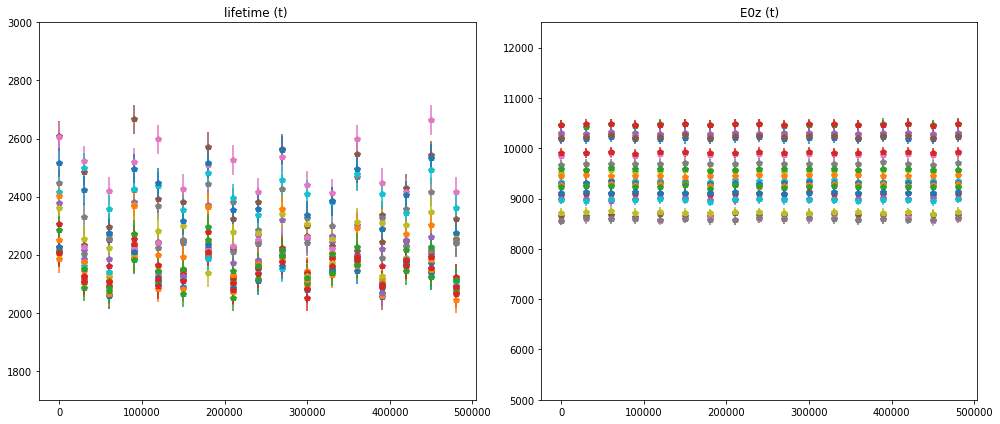

In [161]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1700, 3000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. LT has an structure, splitting in some sectors in two peaks.

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```
Thus, for each radial sector (0, 1, 2...) the function returns a list of objects, one object per phi sector (or wedge). Each object contains 6 time series; ts is time (time difference wrt to the start of the run); e0, lt... are fitted parameters to time slices.

In [162]:
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = (50,550),
               range_e     = (5000, 13000),
               range_chi2  = (0,3),
               range_lt    = (1700, 3300),
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = True)

Fitting sector 0
 number of wedges in sector 24
Fitting sector 1
 number of wedges in sector 24
Fitting sector 2
 number of wedges in sector 24
Fitting sector 3
 number of wedges in sector 24
Fitting sector 4
 number of wedges in sector 24
Fitting sector 5
 number of wedges in sector 24
Fitting sector 6
 number of wedges in sector 24
Fitting sector 7
 number of wedges in sector 24
Fitting sector 8
 number of wedges in sector 24
Fitting sector 9
 number of wedges in sector 24


In [163]:
ts = fmap[0][0].ts

In [164]:
ts

array([     0,  30000,  60000,  90000, 120000, 150000, 180000, 210000,
       240000, 270000, 300000, 330000, 360000, 390000, 420000, 450000,
       480000])

In [165]:
DT

array([     0.        , 519009.03299999, 173376.31100011, ...,
       518979.50099993, 518979.51600003, 518979.53900003])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [166]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

<ErrorbarContainer object of 3 artists>

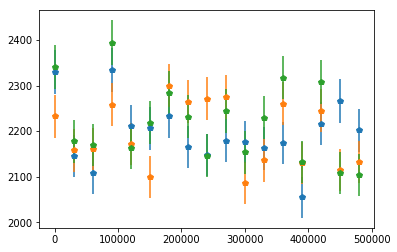

In [167]:
plt.errorbar(ts, tsm.lt[0][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[0][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[0][2], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

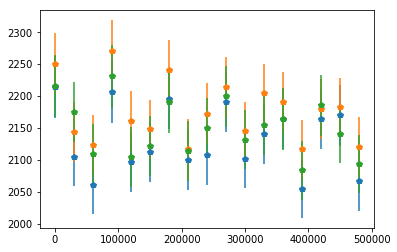

In [168]:
plt.errorbar(ts, tsm.lt[9][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[9][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[9][2], np.sqrt(tsm.lt[0][2]), fmt="p")

#### Obtain ampa from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : Dict[int, List[float]]
    e0    : Dict[int, List[float]]
    lt    : Dict[int, List[float]]
    e0u   : Dict[int, List[float]]
    ltu   : Dict[int, List[float]]
```
In this ASectorMap each wege contains a single number, and thus ASectorMap is really a 
collection of 5 maps. 

#### The map that averages the time series is obtained by setting ts = -1 

In [169]:
am = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))

In [170]:
asm = relative_errors(am)

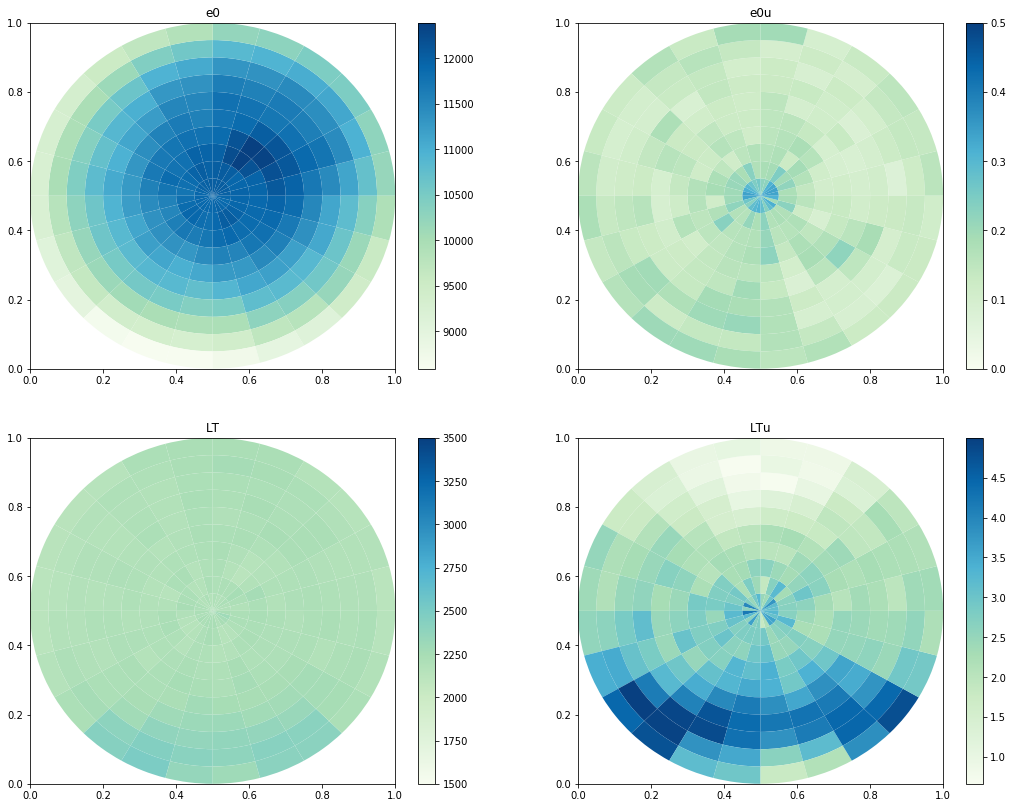

In [171]:
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3500),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### The maps can be saved to file

In [172]:
write_maps(asm, filename=fn.map_file_name)

#### And retrieved from file

In [173]:
me0df, me0udf, mltdf, mltudf = read_maps(filename=fn.map_file_name)

#### To produce a map for a given point in the same series one uses ts = 0, 1... len(ts)

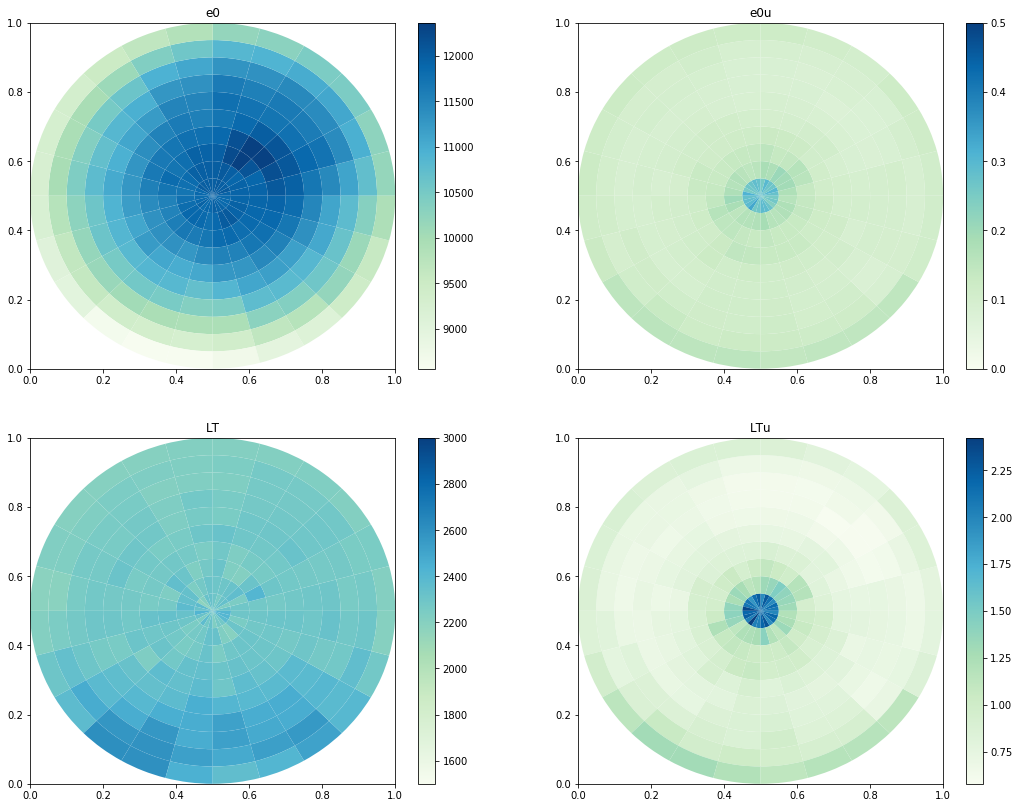

In [174]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

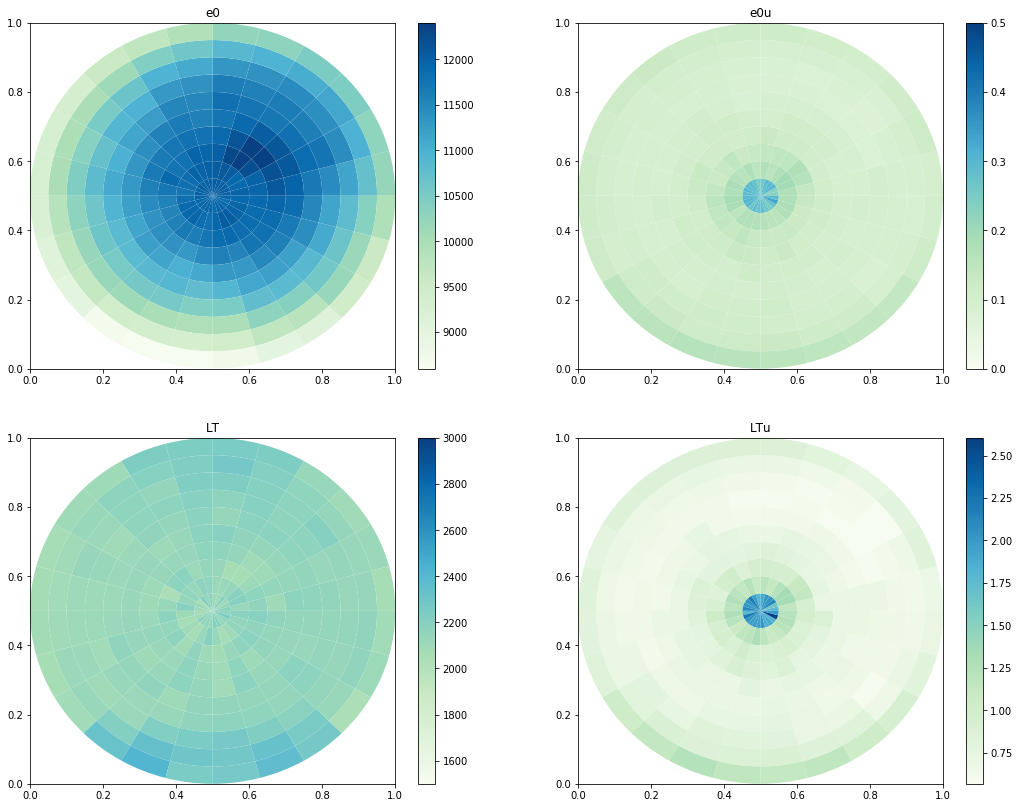

In [175]:
am = amap_from_tsmap(tsm, 
                     ts = len(ts) -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### Full map series:

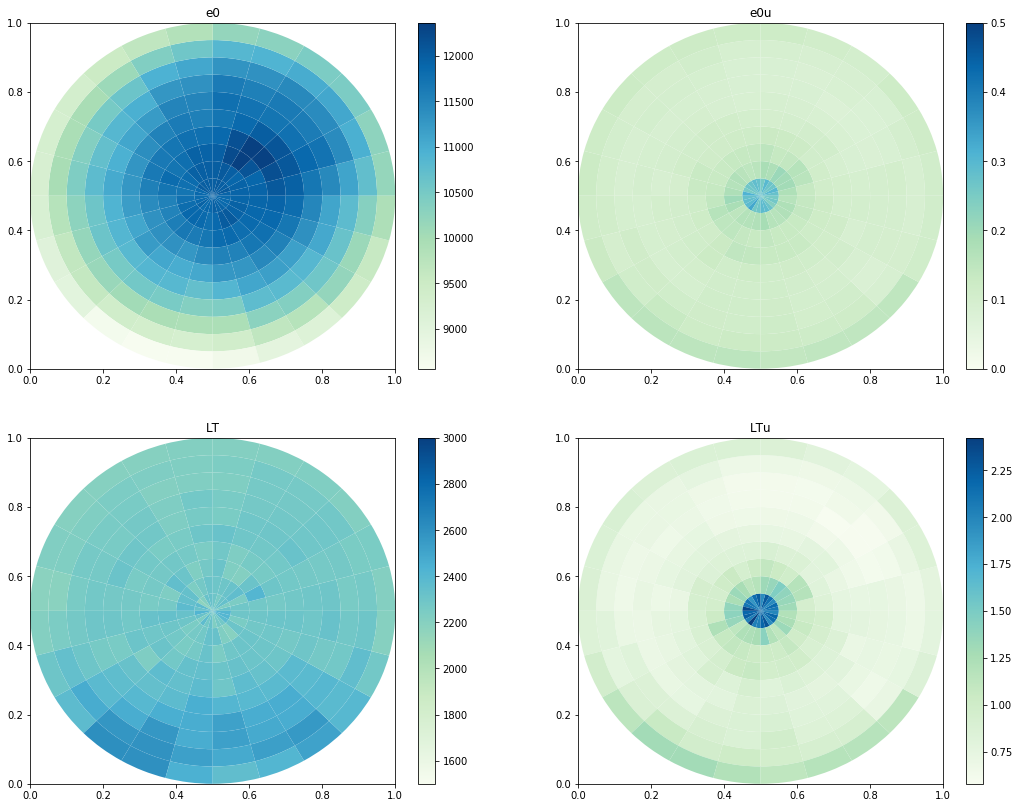

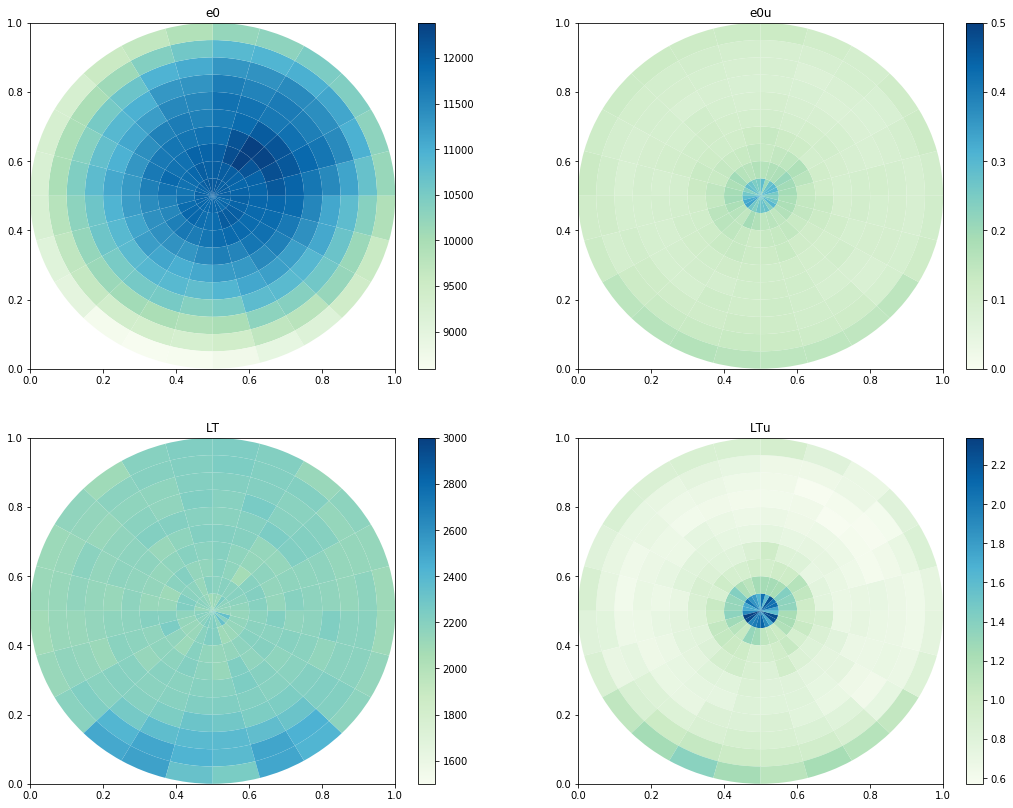

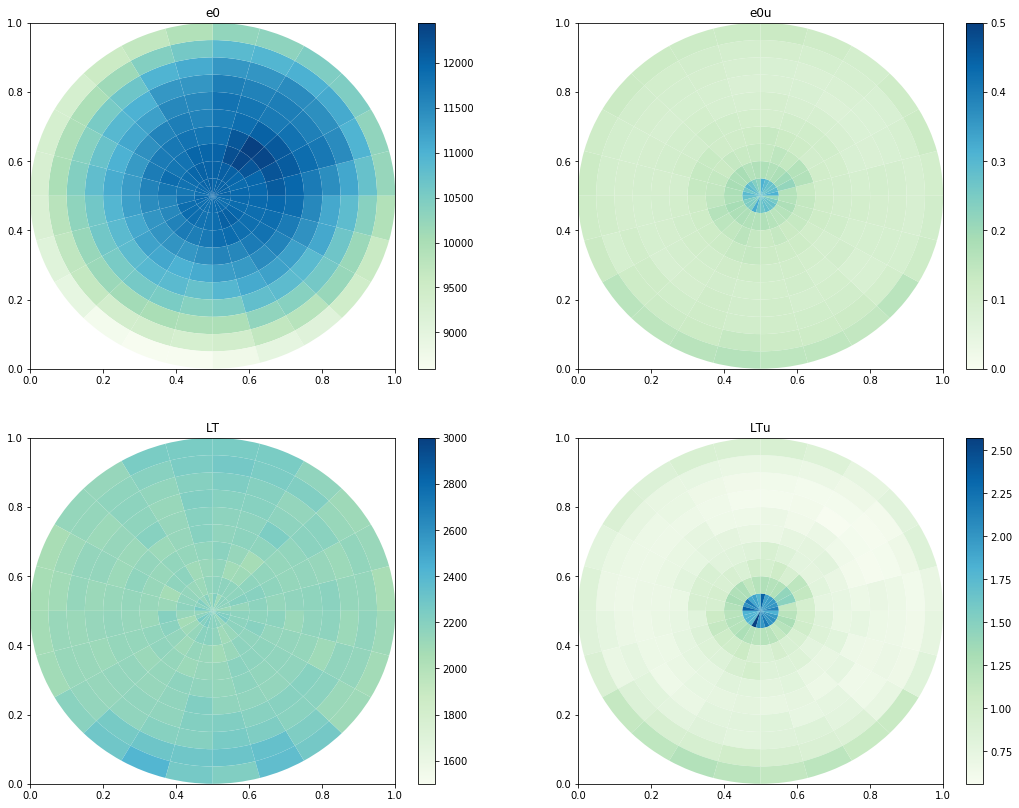

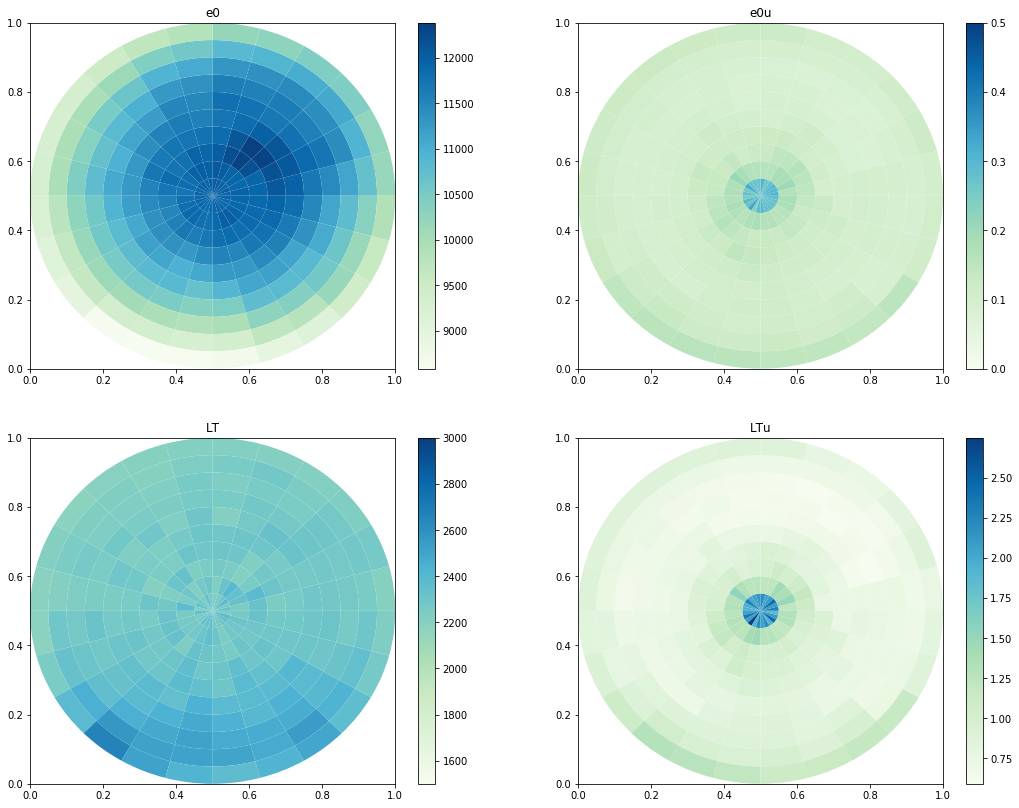

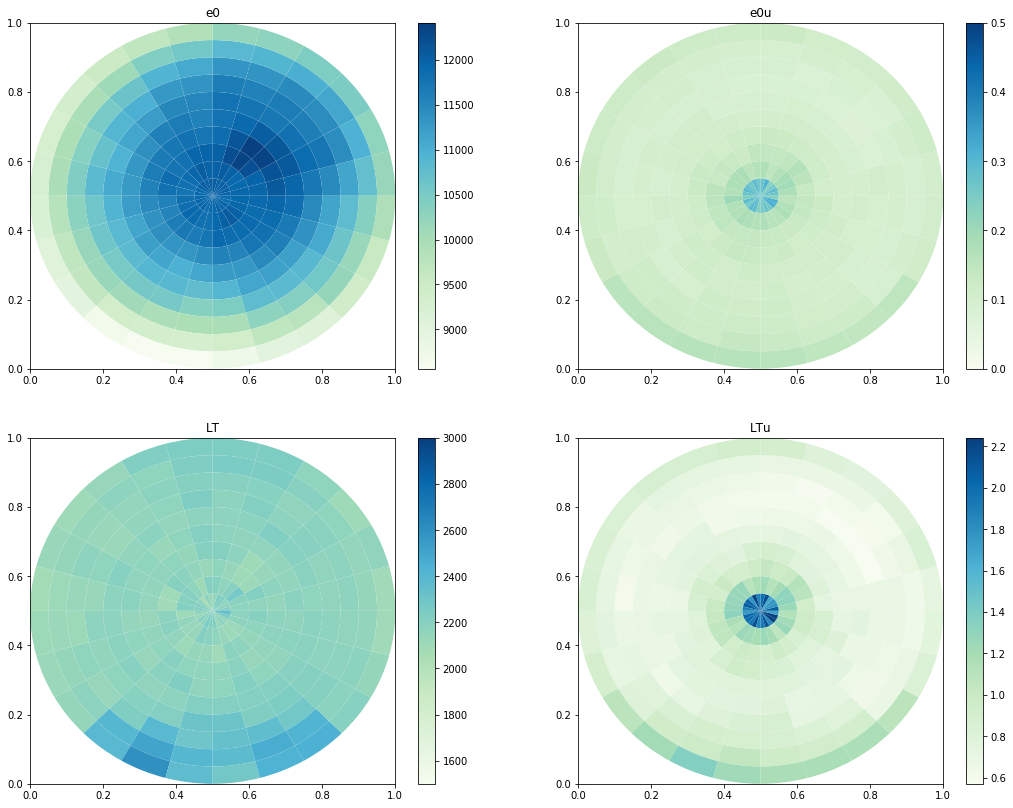

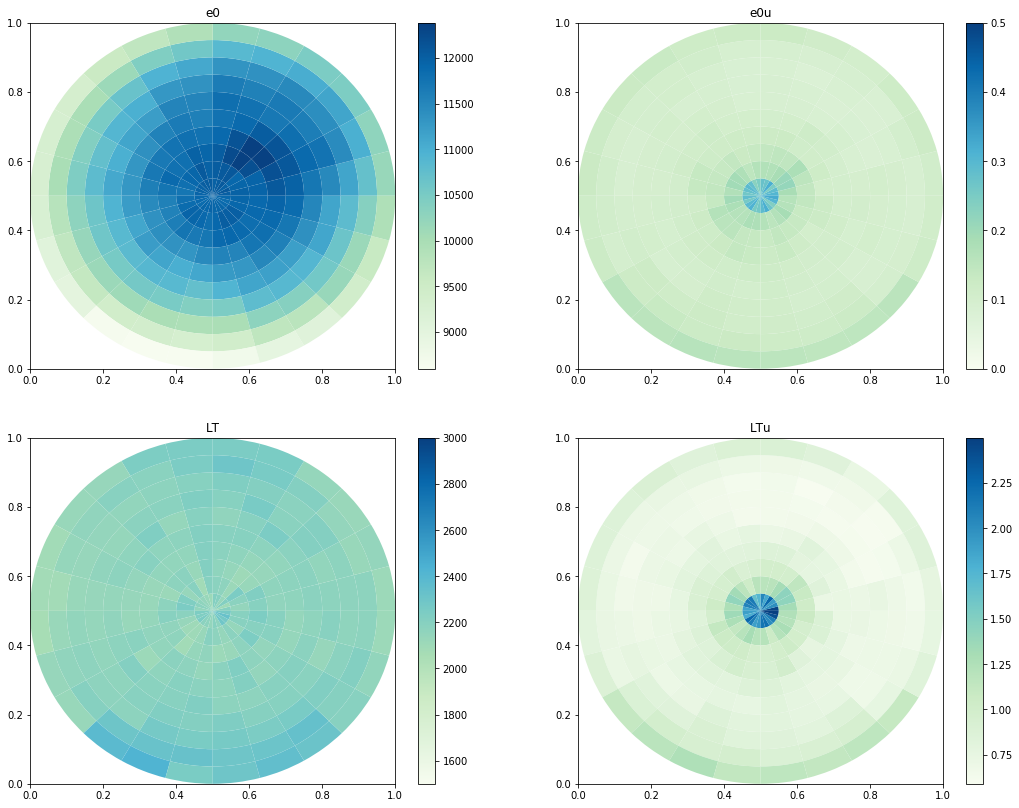

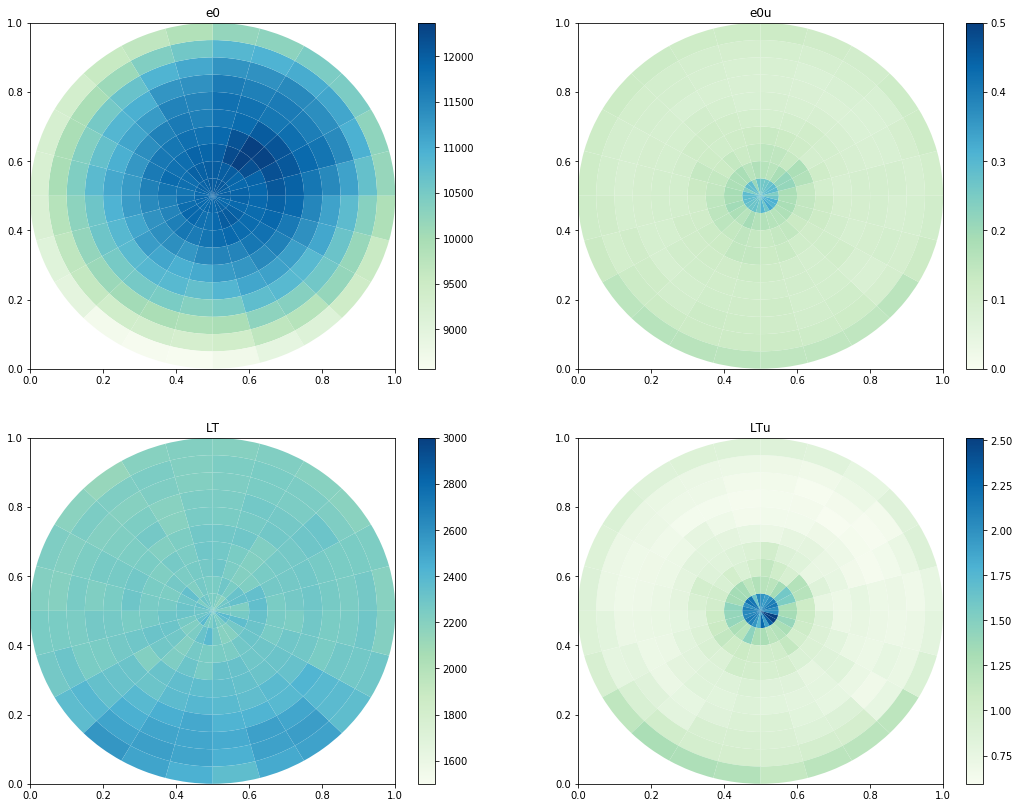

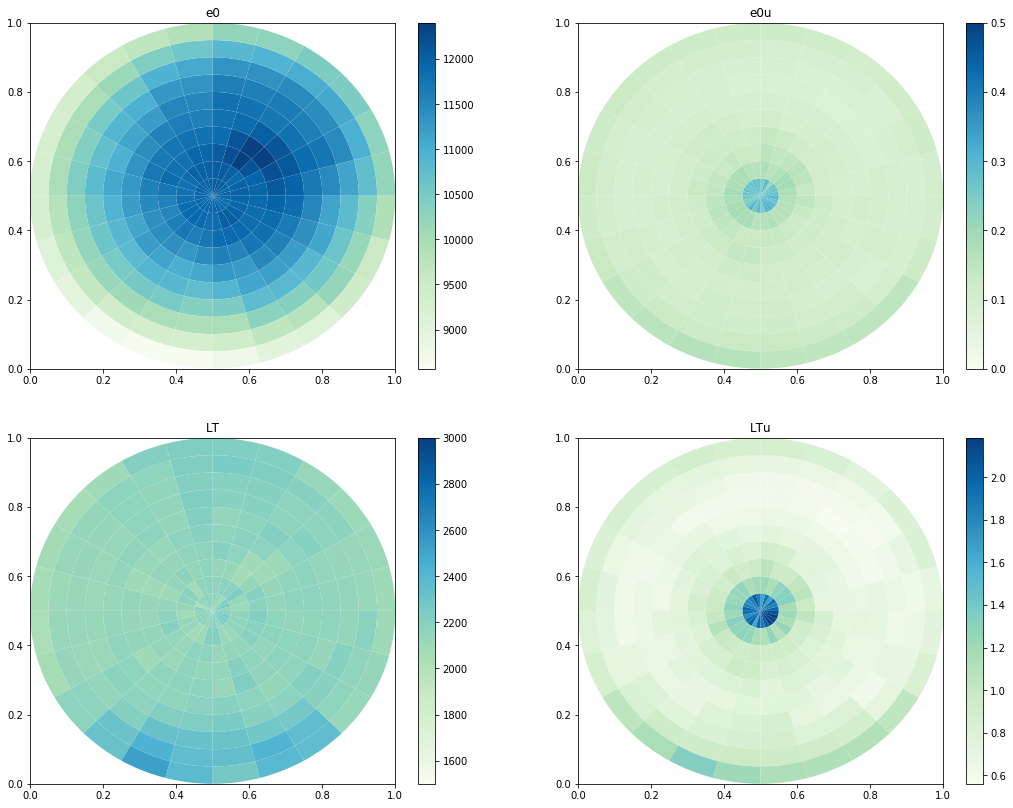

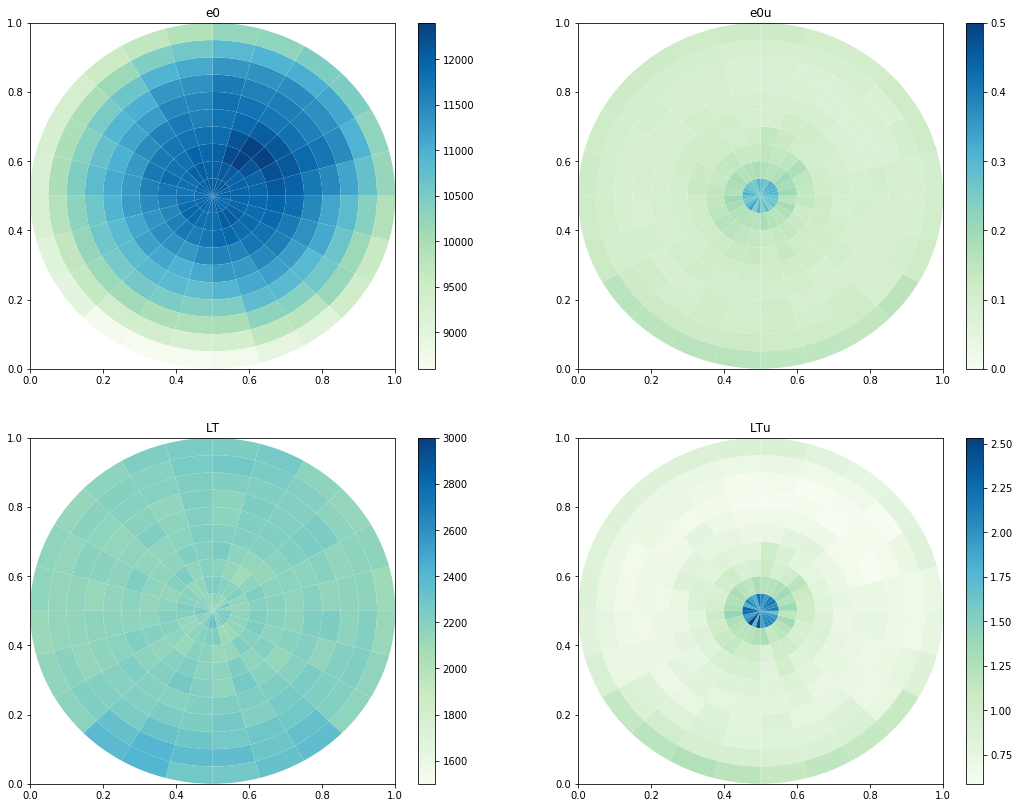

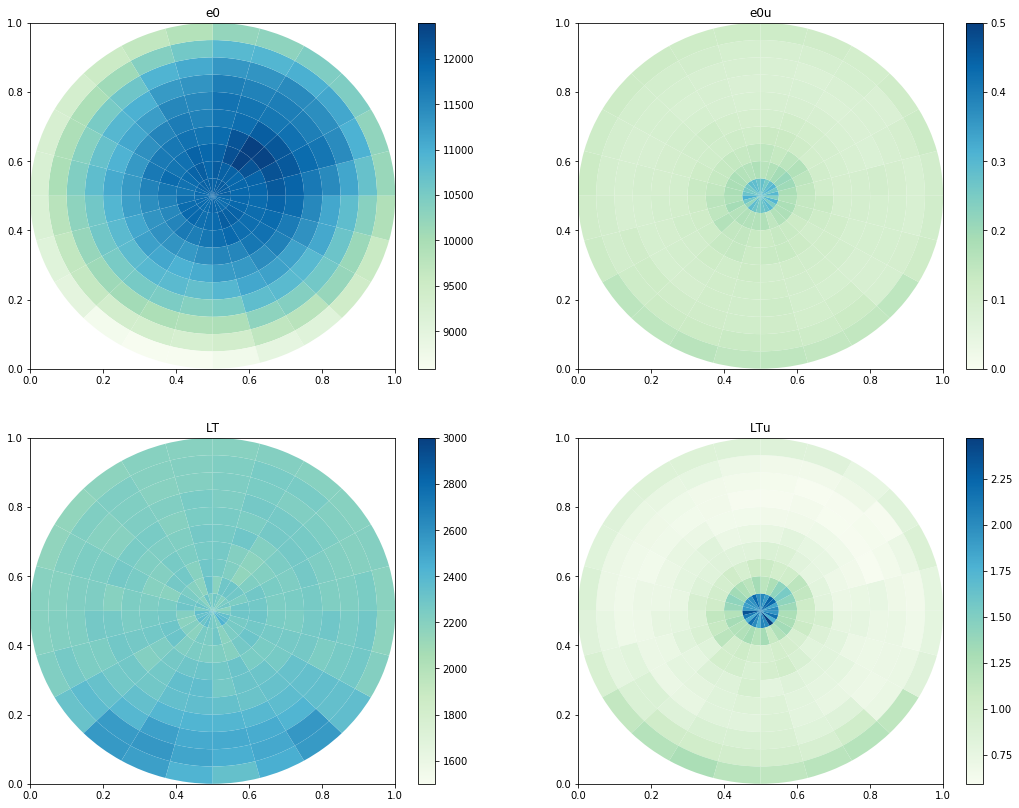

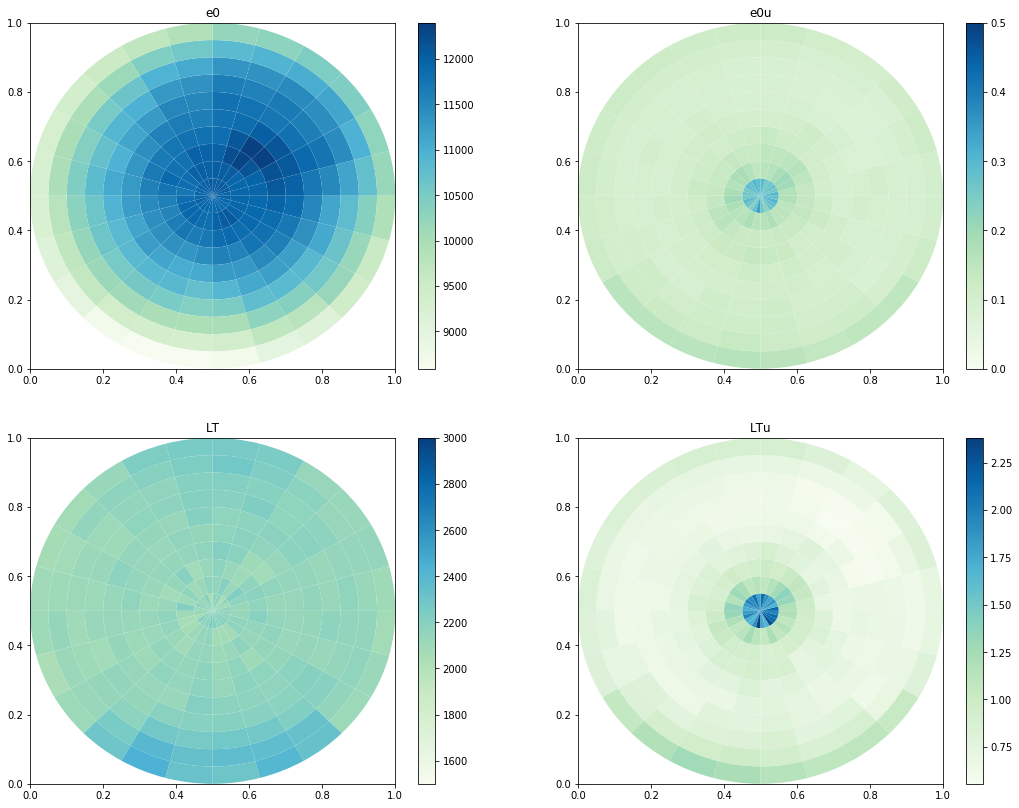

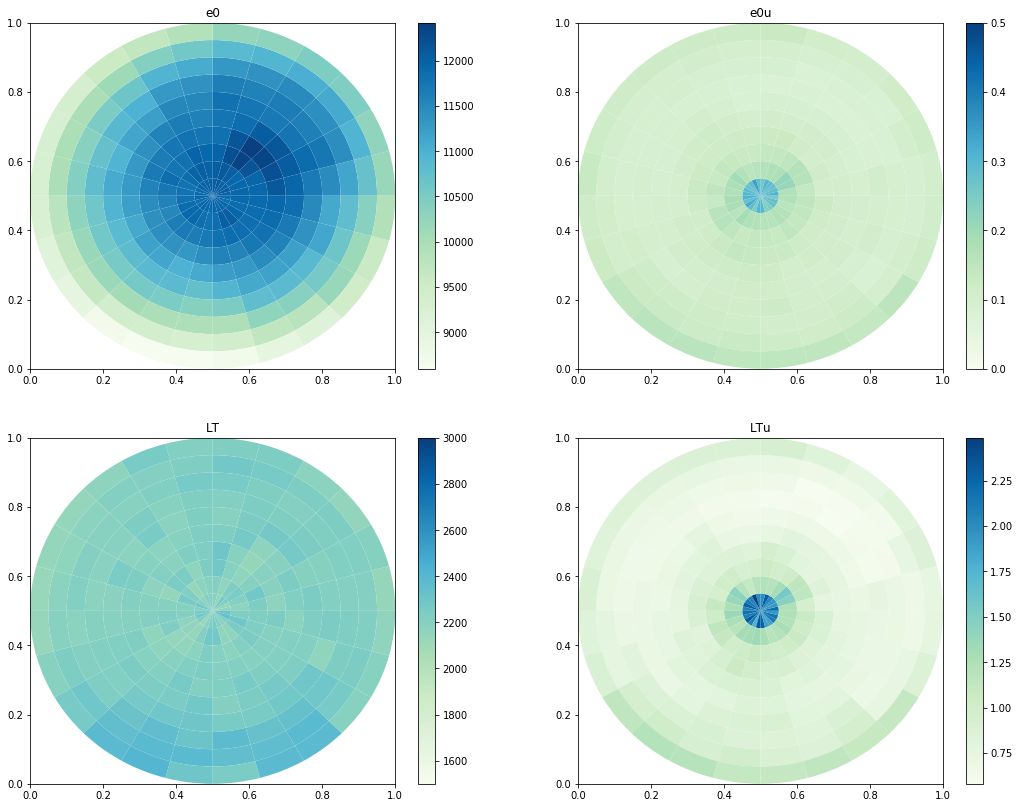

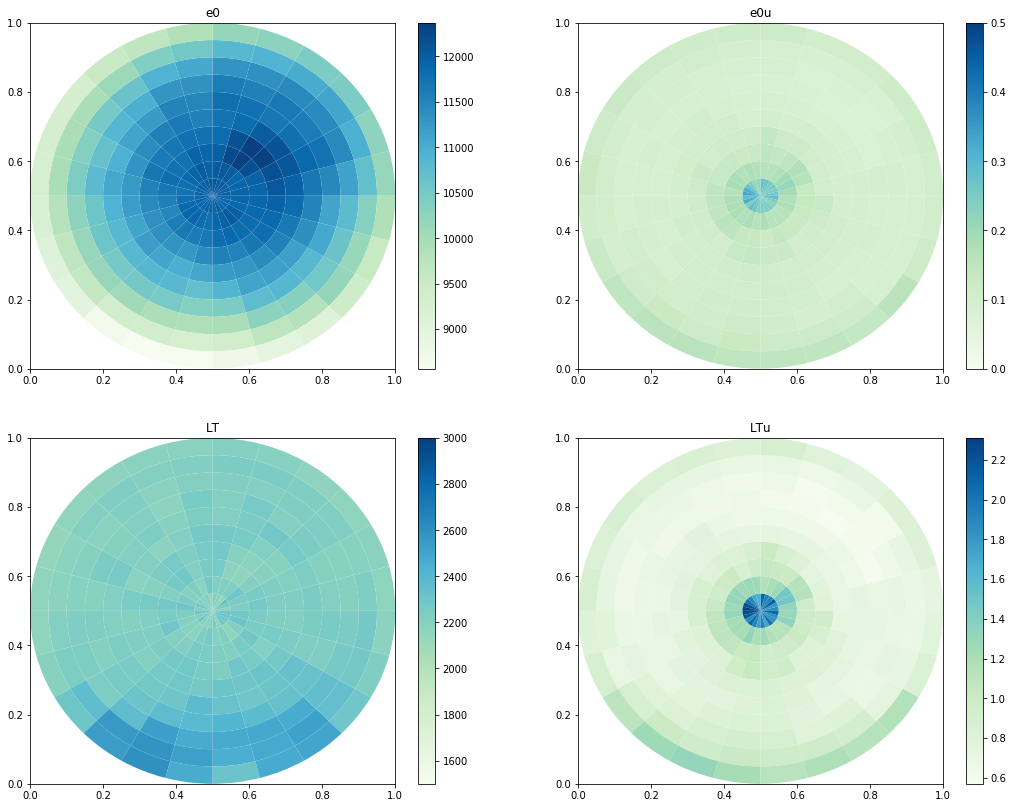

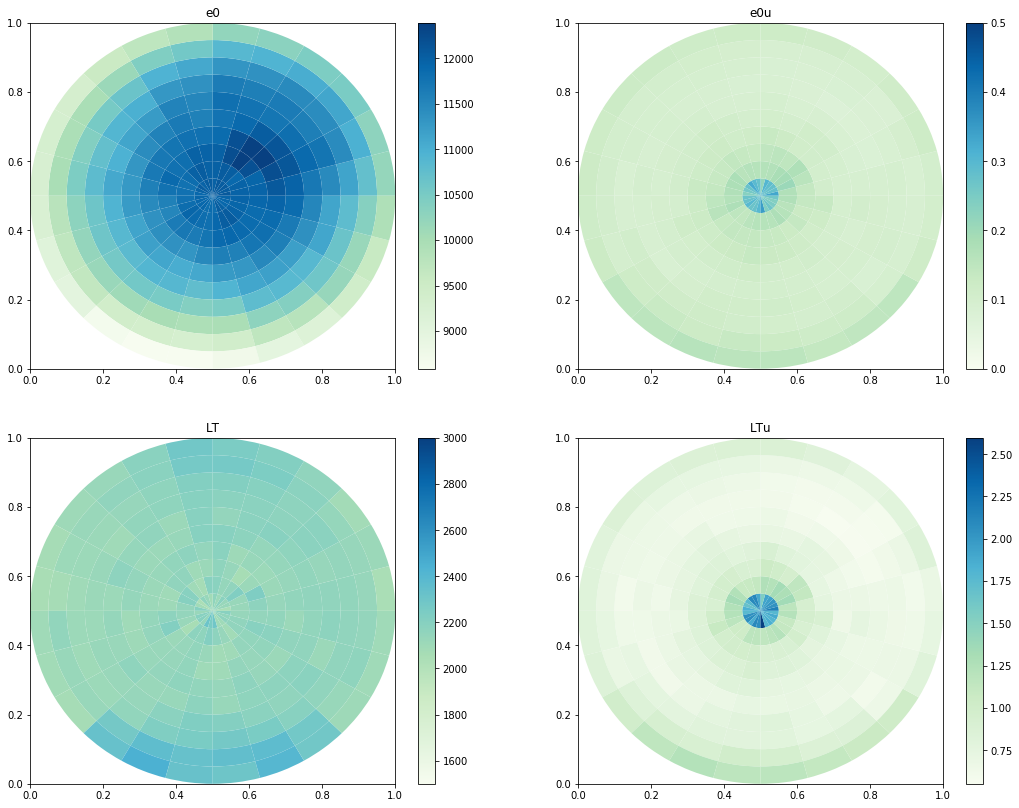

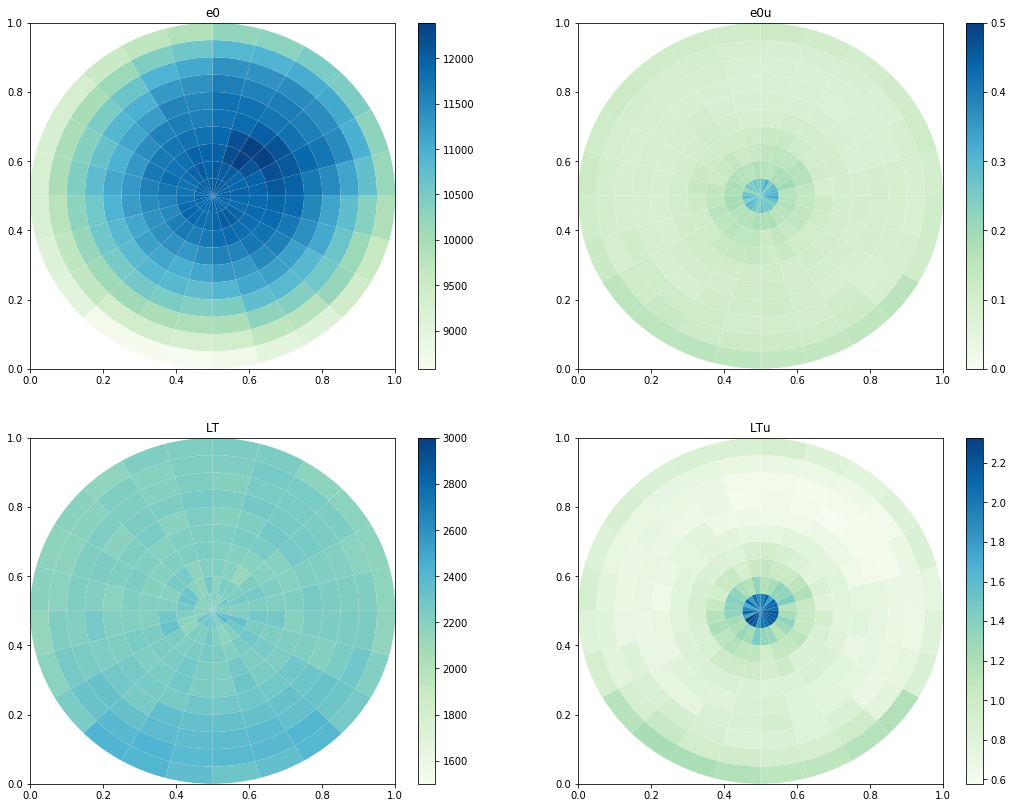

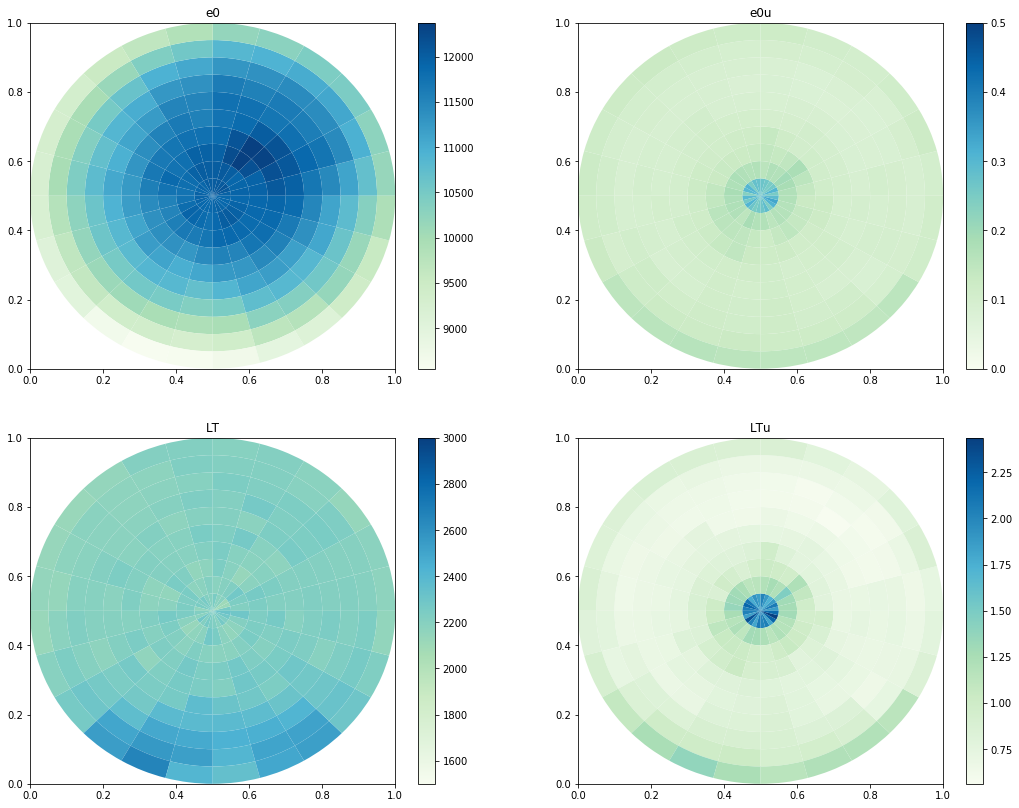

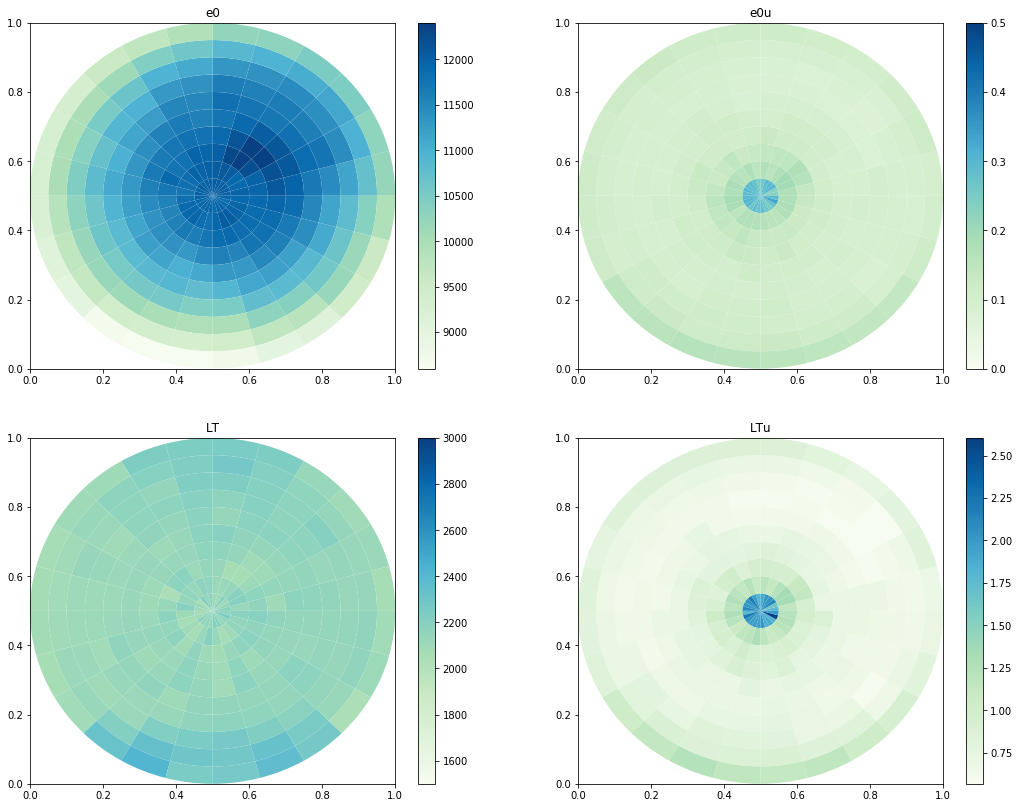

In [176]:
aMaps = []
draw = True
for i, _ in enumerate(ts):
    am = amap_from_tsmap(tsm, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,3),
                         range_lt    = (1700, 3700))
    asm = relative_errors(am)
    aMaps.append(am)
    if draw:
        draw_maps(W, asm,  
                  e0lims  = None,
                  ltlims  = (1500, 3000),
                  eulims  = (0, 0.5),
                  lulims  = None,
                  cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                  alpha   = 1.0,  
                  figsize=(18,14))

#### To write the complete time-series of maps
```
write_maps_ts(aMaps : Iterable[ASectorMap], ts: np.array, filename : str)
```

In [177]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)